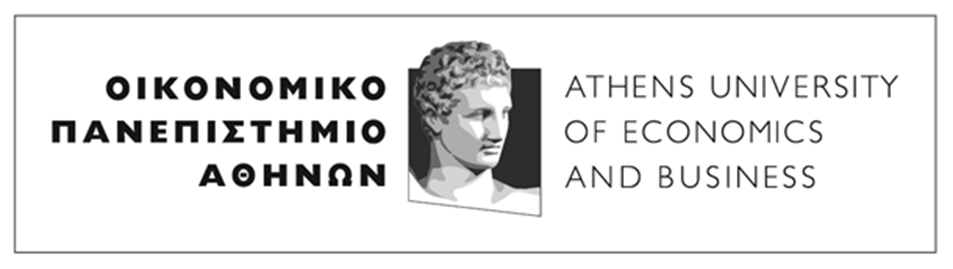

# Classifying recyclable and organic waste using MobileNetV2

### Authors:
**Michail Kalligas,  Panagiotis Lolos**

This notebook contains our entire implementation from data processing to model training and evaluation for our mini-project in the class Machine Learning & Content Analytics.

---



As this entire project was developped and implemented in Google colaboratory, we mounted all libraries and our cloud drive here.

For the code, source material and reasoning behind the implementation please refer to our report.


In [ ]:
import matplotlib.pyplot as plt #used for visualizing useful data
import numpy as np
import os
import tensorflow as tf       #containing all classes used in our architecture
from google.colab import drive #used to mount our cloud drive where we stored the dataset
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping data from mounted google drive to the "content" folder in google colab:

In [ ]:
!unzip -q '/content/drive/MyDrive/MLCA/archive.zip'

Loading train and validation datasets using pathlib and Keras' built-in function for rescaling the images to 160x160 and creating batches of 32 at a time.

In [ ]:
import pathlib 

train_dir = pathlib.Path('/content/DATASET/TRAIN') 
validation_dir=pathlib.Path('/content/DATASET/TEST') 


BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 22564 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2513 files belonging to 2 classes.


Showing the first nine images and labels from the training set to ensure proper loading.

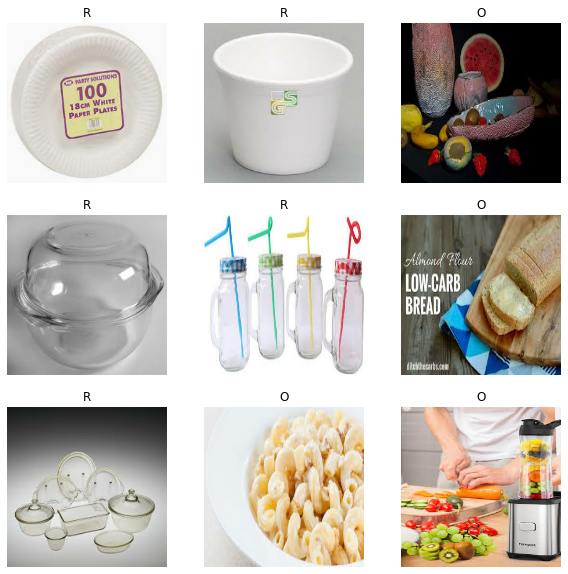

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We will use the TRAIN dataset for training (train_dataset), and the TEST dataset for validation during training (validation_ dataset). Since we dont have a dataset for testing after training, we will create our own by splitting the TEST dataset before training. Empirically, a good ratio for this split according to TensorFlow's documentation would be 20-80 for test-validation respectively.


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 64
Number of test batches: 15


Since we're working in the cloud, we will use TensorFlow's AUTOTUNE and prefetching buffer to reduce I/O blocking.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation
Our dataset contains a relatively small number of images for training and fine-tuning large convolutional models such as MobileNetV2. That's why we create a part of the pipeline containing 4 different data augmentation techniques:
* Random flip horizontally or vertically
* Random rotation of the image by 20%
* Randomly scaling the contrast up or down by a factor of 0.5
* Randomly zooming at parts of the image by 30%

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.5), 
  tf.keras.layers.RandomZoom(0.3),
])

## Testing the data augmentation

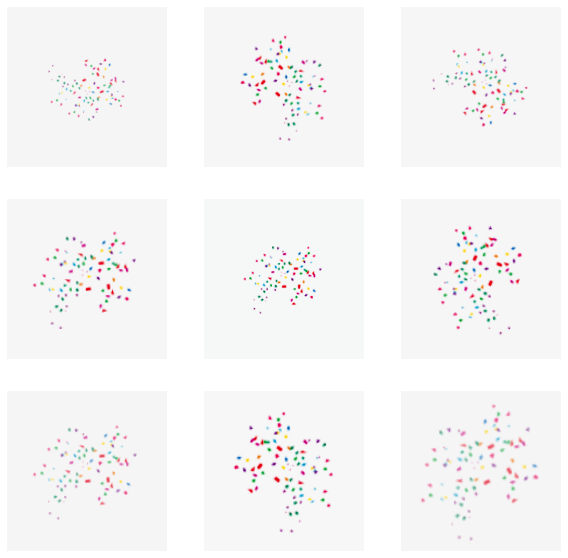

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0),training=True)
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')



## Rescaling pixels

MobileNetV2's acceptable input for pixels is in the range [-1,1], whereas their current values are in the range [0,255] in the RGB mode. TensorFlow has a builtin function which automatically rescales each pixel turning each image into a 160x160x3 embedded image.

Our goal up until now is to retain the images' colors, textures and core shapes, while also augmenting the dataset and transforming it to a useful input for the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Loading the pre-trained model
The base model used is MobileNet V2 developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit, syringe, bottle etc.

We first load an instance of the model along with its' existing weights and initialize it to accept our input images in a scale of 160x160x3. Since our goal is to create our own custom classifier, we exclude the top layers (classification layers) from the model, so that we will add our own.

In [ ]:
# Loading MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,) #setting IMG_SHAPE to 160x160x3
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


We use a feature extractor that converts each 160x160x3 image into a 5x5x1280 block of features. 

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape) #testing

(32, 5, 5, 1280)


# Feature extraction layers

By freezing the convolutional model and retaining the pretrained weights, we can add a few layers for feature extraction as well as our intended classifier for training.



In [ ]:
base_model.trainable = False

In [ ]:
#Current model state
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

We will add a GlobalAveragePooling layer for expansion and use that as the input for classifications/predictions. This will convert the current output from 5x5 to a vector of 1280 elements for each image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Next we use a tf.keras.layers.Dense layer to convert the above output into a single prediction for each image. The prediction we want will be binary, using logit where positive values will be classified as class R and negative values will be classified as class O.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Compiling the completed model
We create our pipeline using Keras' functional approach and adding all of the previously mentioned steps. We also add a steady dropout rate of 0.2 after the global average layer and right before the prediction layer to reduce overfitting risks.

Before compiling we use the Adam optimizer for the base model and a learning rate of 0.0001. Finally, our loss calculation function, as is generally used with classifiers will be binary cross-entropy, which is the most robust evaluator in our case. 

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3)) #inputing images and rescaling accordingly
x = data_augmentation(inputs)       # data augmentation
x = preprocess_input(x)             # automatic preprocessing for the color channels
x = base_model(x, training=False)   # inputing the model and freezing the weights
x = global_average_layer(x)         # average pooling expansion layer
x = tf.keras.layers.Dropout(0.2)(x) # dropout rate for overfitting counter
outputs = prediction_layer(x)       # logit prediction
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. We will train only those.

In [ ]:
len(model.trainable_variables)

2

# Training the model
After many iterations, we found that a good number of epochs for training is between 15 and 20, so we will keep 20 and save the weights using callbacks to prevent overfitting.

For our own evaluations, we first try to predict the validation dataset without any training to see how the basic model performs.

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

64/64 [==============================] - 34s 496ms/step - loss: 1.0121 - accuracy: 0.4063


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.01
initial accuracy: 0.41


In [ ]:
checkpoint_path = "/content/drive/MyDrive/MLCA/checkpoints/feature_extraction_cp_1"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback]
                    )

Epoch 1/20
706/706 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.7258
Epoch 1: val_loss improved from inf to 0.36677, saving model to /content/drive/MyDrive/MLCA/checkpoints/feature_extraction_cp_1
706/706 [==============================] - 494s 693ms/step - loss: 0.5195 - accuracy: 0.7258 - val_loss: 0.3668 - val_accuracy: 0.7787
Epoch 2/20
706/706 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.8563
Epoch 2: val_loss improved from 0.36677 to 0.30594, saving model to /content/drive/MyDrive/MLCA/checkpoints/feature_extraction_cp_1
706/706 [==============================] - 502s 710ms/step - loss: 0.3269 - accuracy: 0.8563 - val_loss: 0.3059 - val_accuracy: 0.8151
Epoch 3/20
706/706 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8778
Epoch 3: val_loss improved from 0.30594 to 0.28773, saving model to /content/drive/MyDrive/MLCA/checkpoints/feature_extraction_cp_1
706/706 [==============================] - 496s 70

# Saving and reloading

In [ ]:
# saving the weights only
# model.save_weights('/content/drive/MyDrive/MLCA/checkpoints/my_checkpoint')

In [ ]:
# saving the entire model
# model.save('/content/drive/MyDrive/MLCA/models/model2')

## Reloading

In [ ]:
# restoring the weights after creating a model with the exact same architecture. Doesn't work properly if the model isn't identical.
model.load_weights('/content/drive/MyDrive/MLCA/checkpoints/finetuning_cp_1')
# model.load_weights('/content/drive/MyDrive/MLCA/checkpoints/feature_extraction_cp_3')

In [ ]:
# reloading a fresh model from the previously saved one, along with the weights
# new_model = tf.keras.models.load_model('/content/drive/MyDrive/MLCA/models/model1')

# # Check its architecture
# new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

# Learning curves
We will use the next blocks to visualize our model's evolution in terms of accuracy and loss, to find insights on how to fine tune it.

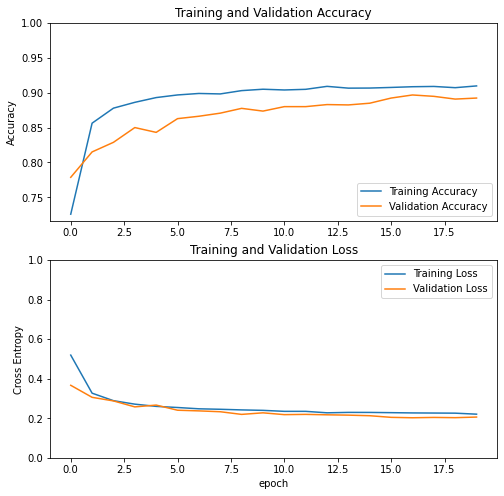

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8)) #Plotting training and validation accuracy evolution
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2) #Plotting training and validation loss evolution
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

Our model has reached satisfactory thresholds in both evaluations, although there is potential for improvement, which we will build upon.
For starters, we will unfreeze 30% of the layers of the pre-trained model and finetune them to our needs. The model is lightweight enough that we can train more than 1.5M parameters without significant cost or stronger equipment than the one we have at our disposal.

In [ ]:
base_model.trainable = True

In [ ]:
# finding the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freezing only the first 100 layers
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Recompiling the model
We will now recompile the model before retraining it. This time, we will use RMSprop (which ignores momentum and optimizes at a lower rate than Adam) for optimization and a much slower learning rate of 0.00001 to prevent overfitting.

The number of trainable parameters this time will be over 1.8M.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

## Re-training the model
Through re-training we expect an improvement of at least a couple of percentage points in accuracy and a significant reduction of loss value.

Note: we ran training several times, the weights of the best model are saved to finetuning_cp_1

In [ ]:
checkpoint_path = "/content/drive/MyDrive/MLCA/checkpoints/finetuning_cp_3"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[cp_callback])

Epoch 20/30
706/706 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9159
Epoch 20: val_loss improved from inf to 0.21431, saving model to /content/drive/MyDrive/MLCA/checkpoints/finetuning_cp_3
706/706 [==============================] - 800s 1s/step - loss: 0.2143 - accuracy: 0.9159 - val_loss: 0.2143 - val_accuracy: 0.9006
Epoch 21/30
706/706 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9258
Epoch 21: val_loss did not improve from 0.21431
706/706 [==============================] - 784s 1s/step - loss: 0.1894 - accuracy: 0.9258 - val_loss: 0.2234 - val_accuracy: 0.8933
Epoch 22/30
706/706 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9283
Epoch 22: val_loss improved from 0.21431 to 0.16434, saving model to /content/drive/MyDrive/MLCA/checkpoints/finetuning_cp_3
706/706 [==============================] - 796s 1s/step - loss: 0.1758 - accuracy: 0.9283 - val_loss: 0.1643 - val_accuracy: 0.9233
Epoch 23/30
706/706

# Evaluating the model

We will first visualize the model's evolution as we did before, to confirm which weights are the better ones. We notice a drastic improvement after finetuning, with an increase in accuracy by 5 percentage points and a decrease in loss by more than 50%. This exceeds expectations.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

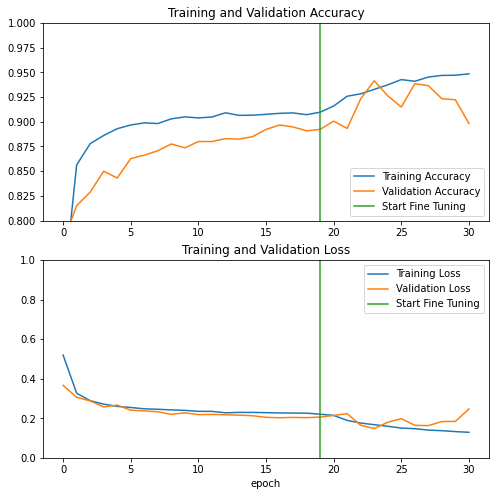

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

15/15 [==============================] - 13s 626ms/step - loss: 0.1390 - accuracy: 0.9521
Test accuracy : 0.9520833492279053


Example predictions

Predictions:
 [0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0]
Labels:
 [0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0]


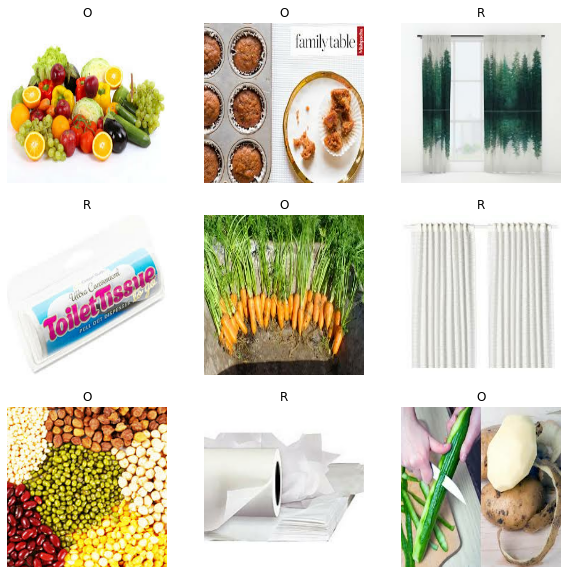

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Single image predictions

In [ ]:
import cv2

def predict_img(dir,name,ext='.png'): 
    img=cv2.imread(dir+name+ext)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    img = cv2.resize(img, (160, 160))
    img = tf.reshape(img, [-1,160,160,3])
    result = tf.where(model.predict(img) < 0.5, 0, 1)
    if result == 0: plt.title('Organic')
    elif result ==1: plt.title('Recyclable')

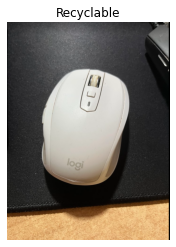

In [ ]:
dir='/content/drive/MyDrive/MLCA/test images/'
name='Screenshot_3'
predict_img(dir,name)

## Crash testing for biases and out-of-sample capabilities

As we try to identify the model's shortcomings and the features it has incorporated, we feed it with specific images with the potential to confuse it. We discuss our hypotheses and conclusions on the matter in our report.

In [ ]:
import math

def predict_dir(dir,n=3):
  '''
  Predicts a folder of images only, given its directory (dir). 
  The user can also set the output's number of photos in the vertical dimension of the 
  grid (default n=3)
  '''
  imlist=os.listdir(dir)
  num=len(imlist)

  plt.figure(figsize=(num*2,num*2))
  
  for i in range(num):
    ax = plt.subplot(n,math.ceil(num/n) , i + 1)
    plt.subplots_adjust(top = 0.99, bottom=0.5)
    predict_img(dir,imlist[i],ext='')

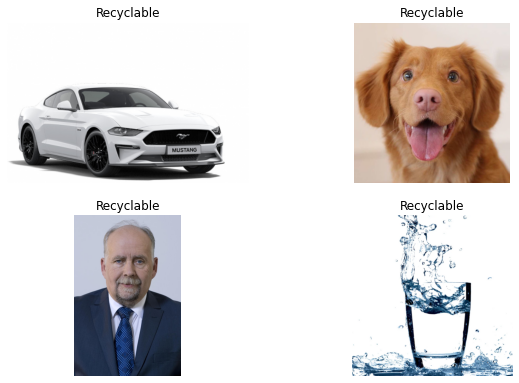

In [ ]:
predict_dir(dir,2)

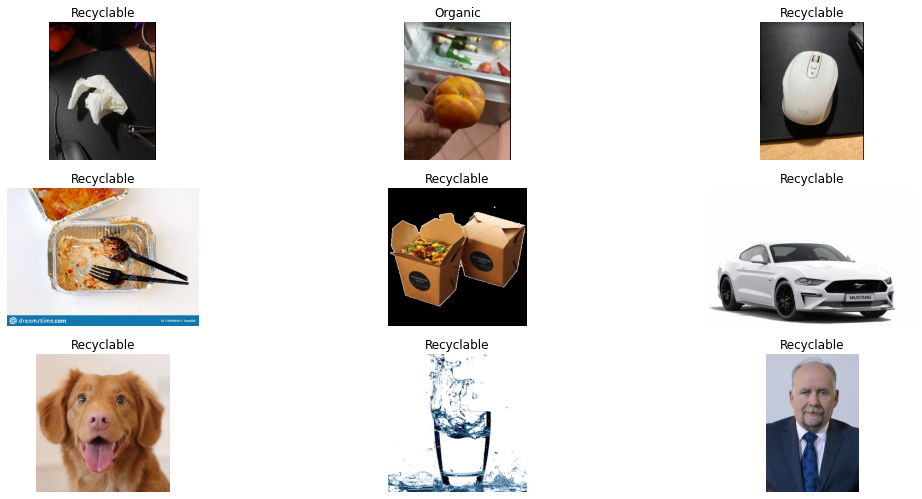

In [ ]:
predict_dir(dir,3)

---
## This marks the end of this notebook.